PHASE 1: DATA QUALITY CHECKS (Python)

 Goal
Before analysis, prove that your data is:

Complete

Consistent

Reliable

Business-valid

STEP 1: Load Datasets (Baseline)

Create= data quality check.ipynb

In [1]:
import pandas as pd
import numpy as np


In [2]:


emp = pd.read_csv('D:\\secl project\\secl dataset\\1_employee_master.csv')



att = pd.read_csv('D:\\secl project\\secl dataset\\2_biometric_attendance.csv')


prod = pd.read_csv('D:\\secl project\\secl dataset\\3_production_financial_summary.csv')





 STEP 2: Shape & Sanity Check (ALWAYS FIRST)

 Confirms:

Data is loaded

No empty tables

Expected volume

In [3]:

print(f"Employee Master Rows & Columns: {emp.shape}")
print(f"Attendance Rows & Columns: {att.shape}")
print(f"Production Rows & Columns: {prod.shape}")




Employee Master Rows & Columns: (450, 6)
Attendance Rows & Columns: (164250, 6)
Production Rows & Columns: (3285, 10)


 STEP 3: Column & Data Type Validation

In [4]:
emp.info()
att.info()
prod.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   employee_id       450 non-null    object
 1   designation       450 non-null    object
 2   role_category     450 non-null    object
 3   employment_type   450 non-null    object
 4   Area              450 non-null    object
 5   experience_years  450 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 21.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164250 entries, 0 to 164249
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               164250 non-null  object 
 1   employee_id        164250 non-null  object 
 2   shift              164250 non-null  object 
 3   attendance_status  164250 non-null  object 
 4   work_hours         164250 non-null  int64  
 5   overtime_hours     

What a real analyst checks:

Dates should be datetime

IDs should be object

Costs should be numeri

Fix if needed:

In [5]:
att['date'] = pd.to_datetime(att['date'], errors='coerce')
prod['date'] = pd.to_datetime(prod['date'], errors='coerce')
att['date'].dtype



dtype('<M8[ns]')

 STEP 4: Primary Key Integrity
Employee Master

In [6]:
emp['employee_id'].is_unique


True

Attendance Table
Expected: 0
 Non-zero = double punch issue

In [7]:
duplicate_att = att.duplicated(
    subset=['employee_id', 'date', 'shift']
).sum()

print("Duplicate attendance records:", duplicate_att)


Duplicate attendance records: 98100


 STEP 4: Foreign Key (Referential Integrity)

In [8]:
invalid_emp = att.loc[
    ~att['employee_id'].isin(emp['employee_id'])
]

print("Invalid employee records in attendance:", invalid_emp.shape[0])


Invalid employee records in attendance: 0


 STEP 5: Missing Value Analysis (Business Logic Based)
 Business interpretation

work_hours = 0 → acceptable for Absent

coal_production_tonnes → NEVER NULL

Net_Profit_INR → NEVER NULL

 Nulls in production = data pipeline failure

In [9]:
emp_null  = emp.isnull().sum()
att_null  = att.isnull().sum()
prod_null = prod.isnull().sum()

emp_null, att_null, prod_null


(employee_id         0
 designation         0
 role_category       0
 employment_type     0
 Area                0
 experience_years    0
 dtype: int64,
 date                 99450
 employee_id              0
 shift                    0
 attendance_status        0
 work_hours               0
 overtime_hours           0
 dtype: int64,
 date                      1989
 area                         0
 shift                        0
 coal_production_tonnes       0
 target_production            0
 critical_roles_present       0
 total_wage_cost              0
 Total_Cost_INR               0
 Revenue_INR                  0
 Net_Profit_INR               0
 dtype: int64)

 STEP 6: Attendance Business Rule Validation
❌ Absent but working
❌ Unrealistic work hours

In [10]:
invalid_attendance = att.query(
    "attendance_status == 'Absent' and work_hours > 0"
)

invalid_attendance.shape


(0, 6)

In [11]:

invalid_hours = att.query("work_hours < 0 or work_hours > 16")
invalid_hours.shape


(0, 6)

STEP 7: Production Business Rules
❌ Negative production
❌ Negative manpower

In [12]:
prod.query("coal_production_tonnes < 0") 




,date,area,shift,coal_production_tonnes,target_production,critical_roles_present,total_wage_cost,Total_Cost_INR,Revenue_INR,Net_Profit_INR


In [13]:
prod.query("critical_roles_present < 0")

,date,area,shift,coal_production_tonnes,target_production,critical_roles_present,total_wage_cost,Total_Cost_INR,Revenue_INR,Net_Profit_INR



STEP 8: Outlier Detection (Operational Risk)
 Analyst insight:

Low production + high manpower → absenteeism / machine downtime

In [14]:
prod['coal_production_tonnes'].describe()


count    3285.000000
mean     5158.939802
std       564.972426
min      3212.350000
25%      4780.420000
50%      5186.920000
75%      5545.680000
max      6910.710000
Name: coal_production_tonnes, dtype: float64

<Axes: >

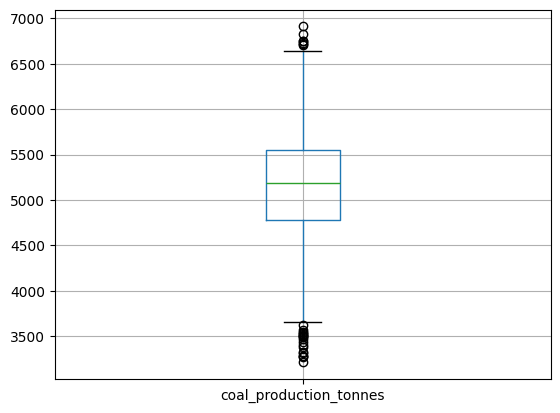

In [15]:
prod.boxplot(column='coal_production_tonnes')


🔹 STEP 9: Data Quality Summary Report (Executive-Ready)


In [16]:
dq_summary = pd.DataFrame({
    'Metric': [
        'Employee Master Rows',
        'Attendance Rows',
        'Production Rows',
        'Duplicate Attendance Records',
        'Invalid Employee IDs',
        'Absent but Worked Records',
        'Invalid Work Hour Records'
    ],
    'Value': [
        emp.shape[0],
        att.shape[0],
        prod.shape[0],
        duplicate_att,
        invalid_emp.shape[0],
        invalid_attendance.shape[0],
        invalid_hours.shape[0]
    ]
})

dq_summary


,Metric,Value
0,Employee Master Rows,450
1,Attendance Rows,164250
2,Production Rows,3285
3,Duplicate Attendance Records,98100
4,Invalid Employee IDs,0
5,Absent but Worked Records,0
6,Invalid Work Hour Records,0
